### Modèle (S)ARIMA-GARCH

Avant de commencer, il est bon de préciser que le modèle **ARIMA-GARCH** n'est jamais optimal avec Python, support sur lequel les deux composantes du modèle ne peuvent être appliquées que de façon successive (d'abord GARCH puis ARIMA, ou inversement). Le modèle obtenu après avoir appliqué GARCH (respectivement ARIMA) constituera donc un biais pour l'output de l'application ARIMA (respectivement GARCH) qui suit. Il est donc préférable de procéder à l'aide d'un logiciel de statistiques comme eViews, ou à l'aide d'un autre langage de programmation comme R. 

Nous allons extraire ici les cours de clôture du **boisseau de blé** (série temporelle saisonnière par excellence), et si les données le permettent, nous lui appliquerons le modèle SARIMA ; dérivé du modèle ARIMA permettant de capturer le caractère saisonnier d'une série temporelle.

### Bibliothèques

Nous utiliserons les bibliothèques *pandas*, *matplotlib.pyplot*, *statsmodels* et *pmdarima*.
Dans un souci de lisibilité, nous les importerons toutes (même si la plupart ont été importées plus haut).

In [3]:
!pip install pmdarima
import pandas as pd
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

Nous allons désormais extraire et structurer les données *YahooFinance*, avant d'établir un graphique de l'évolution des cours du boisseau de blé depuis le 1er Janvier 2023 jusqu'à la dernière date disponible :

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

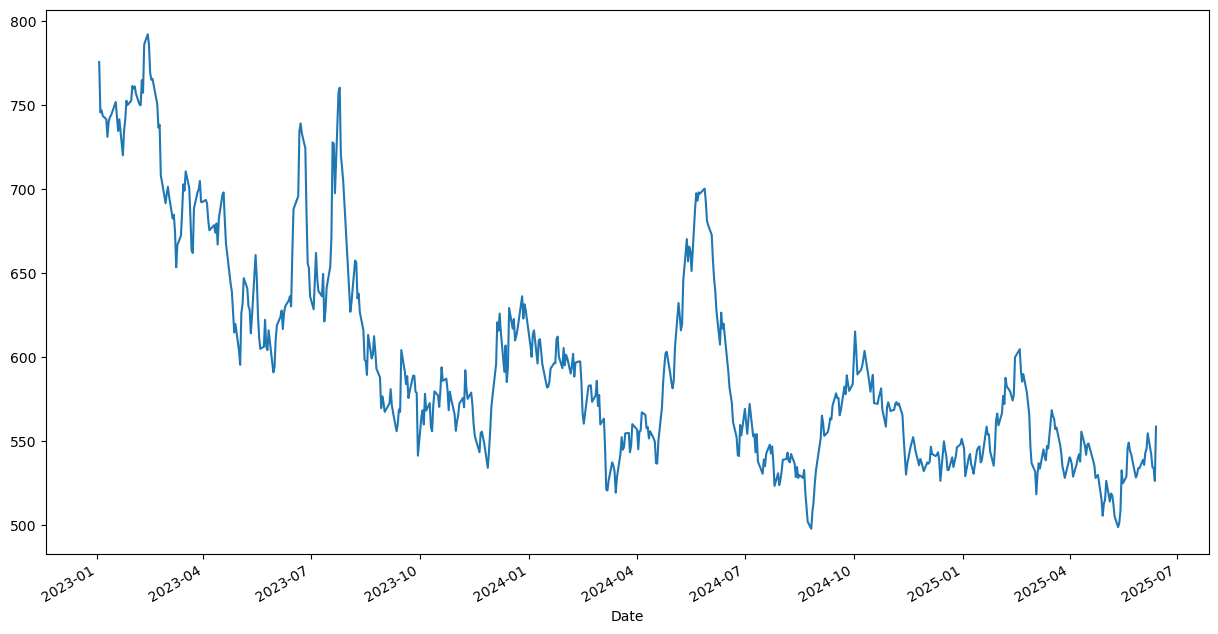

In [4]:
df = yf.download("ZW=F", interval = "1d").Close
df.to_csv("ZWF")
df = pd.read_csv("ZWF", index_col = [0], parse_dates = [0])
df.rename(columns = {"ZW=F" : "Close"}, inplace = True)
df.loc["2023-01-01":,"Close"].plot(figsize = (15, 8))

Nous avons ci-dessus le graphique de l'évolution des prix des *Chicago SRW Wheat futures* (focus sur 2023 pour mieux percevoir la saisonnalité). Ceux-ci ont tendance à baisser lorsque l'offre augmente à l'automne (saison des récoltes), puis à remonter jusqu'au début du printemps, avant de se stabiliser. Cette série est donc bien saisonnière.

Test de Dickey-Fueller :

In [5]:
result = adfuller(df.Close)
print(f"p-valeur : {result[1]:.3f}")

p-valeur : 0.047


Nous avons ici affaire à une série temporelle décrivant l'évolution brute des prix du *benchmark*. Comme le reste des séries décrivant l'évolution des cours d'un sous-jacent, celle-ci n'est pas stationnaire - comme nous le confirme la p-valeur tout juste inférieure à 0.05 ; nous ne pouvons donc pas lui appliquer de modèle ARMA tel quel. Nous allons donc analyser les rendements logarithmiques de la série (différenciation 1).

In [6]:
df.Close = np.log(df.Close.div(df.Close.shift(1))) ## Rendements logarithmiques
df.dropna(inplace = True)
df

,Close
Date,
2000-07-18,-0.011334
2000-07-19,0.015424
2000-07-20,0.008130
2000-07-21,0.001012
2000-07-24,-0.007103
...,...
2025-06-09,-0.023252
2025-06-10,-0.013934
2025-06-11,-0.000468


Appliquons de nouveau le test de Dickey-Fueller :

In [7]:
result = adfuller(df.Close)
print(f"p-valeur : {result[1]:.3f}")

p-valeur : 0.000


Nous obtenons une p-valeur bien inférieure à 0.05 ; la série n'a donc pas de racine unitaire : elle est stationnaire. De notre modèle ARIMA(p,d,q), nous avons donc d = 1, car nous n'avons eu qu'à différencier une seule fois.
Désormais, nous utiliserons la bibliothèque *pmdarima* pour trouver automatiquement les meilleurs paramètres possibles pour notre série, en analysant chaque cas de figure.

In [37]:
model = pm.auto_arima(
    yf.download("ZW=F", interval = "1wk").Close,
    m = 52,                     ## Analyse à intervalles hebdomadaires pour limiter le temps d'exécution du programme
    seasonal = True,            ## Série saisonnière
    max_p = 3,                  ## Borner les paramètres pour limiter le temps d'exécution du programme
    max_q = 3,                  ## ''
    max_P = 3,                  ## ''
    max_Q = 3,                  ## ''
    stepwise = True,            ## Limite le temps de recherche (au détriment de la précision)
    trace = True                ## Affiche chaque essai
)

[*********************100%***********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=50.09 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=12554.842, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=12544.375, Time=7.25 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=12543.674, Time=8.92 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=12552.923, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=12542.906, Time=0.50 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=12543.720, Time=8.24 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=22.73 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=12544.787, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=12544.678, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=12543.515, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=12542.038, Time=1.40 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=12542.697, Time=25.53 sec
 ARIMA(1,1,2)(0,0,1)[52] intercept   : AIC=12542.638, Time=25.84 sec
 ARIMA(1,1,2)

Nous avons ci-dessus le résultat de la recherche des paramètres du modèle SARIMA à appliquer à notre série temporelle. Comme vu plus haut, différencier la série une seule fois suffit bel et bien.
Nous constatons que le meilleur modèle au sens de l'AIC est le modèle ARIMA(2,1,2)(0,0,0)[52].
Le premier élément frappant est que le modèle privilégie le fait de ne pas prendre en compte la saisonnalité de la série. Cela est dû au fait que l'AIC privilégie les modèles plus simples pour éviter l'overfitting ; ainsi, l'information apportée par des potentiels paramètres de saisonnalité ne vaut pas la complexité qu'elle donne au modèle, qui deviendrait alors biaisé.

D'un point de vue mathématique, la méthode *pm.auto_arima* cherche le tuple : $[(p,d,q),(P,D,Q)]$ qui minimise l'AIC.
Ce dernier s'exprime de la façon suivante :

$$
\mathrm{AIC} = 2k - 2 \ln(\hat{L})
$$

où :  
- $k$ est le nombre de paramètres estimés **non-nuls** dans le modèle,  
- $\hat{L}$ est la valeur maximale de la vraisemblance du modèle.

En cherchant à minimiser l'AIC, on cherche donc à :
- Minimiser $k$,
- Maximiser $(\hat{L})$ (car le logarithme népérien est strictement croissant sur $\mathbb{R}^{+*}$, et que la fonction de vraisemblance, en tant que densité de probabilité portant sur des gaussiennes, est ***strictement* positive** sur $\mathbb{R}^{k}$).

Ici, le point précis du plan $\mathbb{R}^{p+d+q} \times \mathbb{R}^{P+D+Q}$ minimisant l'AIC satisfait donc $[(p,d,q)(P,D,Q)] = [(2,1,2),(0,0,0)]$. Maintenant que nous avons le nombre de coefficients $AR$ et $MA$ nécessaires pour établir notre modèle, nous allons en chercher les valeurs.

---

**Remarque :**  
- Plus l'AIC est faible, meilleur est le modèle (équilibre entre qualité du fit et complexité).  
- L'AIC ne donne pas une mesure absolue, mais permet de comparer plusieurs modèles.

In [9]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1300
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -6262.567
Date:                Sun, 15 Jun 2025   AIC                          12535.133
Time:                        10:20:52   BIC                          12560.980
Sample:                    07-17-2000   HQIC                         12544.831
                         - 06-09-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0167      0.108     -9.413      0.000      -1.228      -0.805
ar.L2         -0.4991      0.119     -4.207      0.000      -0.732      -0.267
ma.L1          0.9174      0.110      8.362      0.0

## Expression du modèle :

$Y_t = \mu - 1,0187(Y_{t-1} - \mu) - 0,5003(Y_{t-2} - \mu) + {\epsilon}_t + 0,9193{\epsilon}_{t-1} + 0,3799{\epsilon}_{t-2}$

où $Y_t = \log\left(\frac{P_t}{P_{t-1}}\right)$ désigne le **rendement logarithmique** de la série $\texttt{ZW=F}$, et $\Delta Y_t = Y_t - Y_{t-1}$ est la série différenciée sur laquelle le modèle ARIMA(2,1,2) est estimé.

[*********************100%***********************]  1 of 1 completed


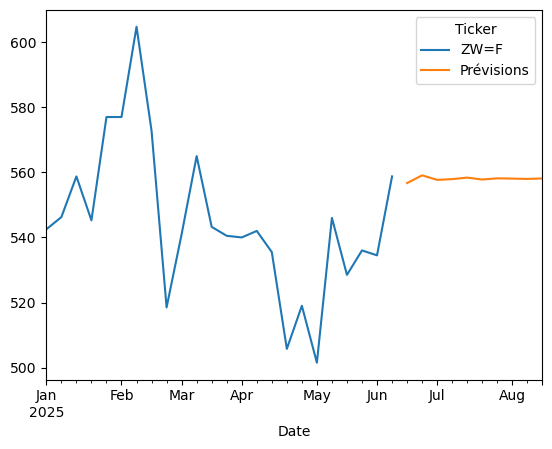

In [56]:
plt.close()
df_plot = yf.download("ZW=F", start = "2025-01-01", interval = "1wk").Close
df_plot.plot()
pd.Series(np.array(model.predict(n_periods = 10)), index = pd.date_range(start = df_plot.index[-1] + pd.Timedelta(weeks = 1), periods = 10, freq = "W-WED")).plot(legend = True, label = "Prévisions")
plt.show()

L'analyse semble peu concluante : Nous procéderons à une analyse des graphiques ACF (*AutoCorrelation Function*) et PACF (*Partial AutoCorrelation Function*). 